<a href="https://colab.research.google.com/github/plaban1981/Pytorch_lightning/blob/main/Detect__Trees_Near_Electric_Wires_using_pytorch_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Pytorch Lightning and other required packages

In [2]:
%%capture
!pip install pytorch_lightning

In [7]:
%%capture
!pip install lightning-bolts

In [9]:
%%capture
!pip install wandb

In [10]:
import warnings
warnings.filterwarnings('ignore')

## Import Pytorch Lightning Packages

In [60]:
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint,EarlyStopping
from pl_bolts.models.self_supervised import SwAV
#
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader,random_split
from torchvision import models,transforms,datasets

## Download the images

In [12]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1ahtCipPXsX9BVRWi6nDG13tr4b_rMY97',
dest_path='content/detect_trees_near_electric_wires.zip',
unzip=True)

Unzipping...Done.


## Import Python and respective data processing libraries

In [13]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
import os # OS module in Python provides a way of using operating system dependent functionality
import shutil
import cv2 # Library for image processing
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set


## Loading and preparing training data

In [14]:
train = pd.read_csv("/content/content/detect_trees_near_electric_wires/train.csv") # loading the labels
train.head() # will display the first five rows in labels dataframe

,file_name,Intersection
0,Image_1.jpg,0
1,Image_2.jpg,1
2,Image_3.jpg,1
3,Image_4.jpg,1
4,Image_5.jpg,1


## Adding Filepath to the dataframe

In [15]:
train['file_name'] = "/content/content/detect_trees_near_electric_wires/train/" + train['file_name']

In [16]:
train.head()

,file_name,Intersection
0,/content/content/detect_trees_near_electric_wi...,0
1,/content/content/detect_trees_near_electric_wi...,1
2,/content/content/detect_trees_near_electric_wi...,1
3,/content/content/detect_trees_near_electric_wi...,1
4,/content/content/detect_trees_near_electric_wi...,1


## Checking if the training data isbalanced

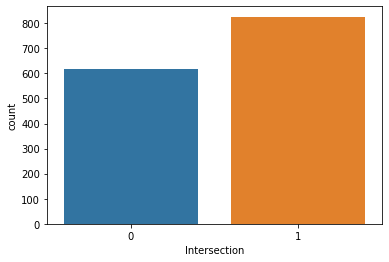

In [17]:
import seaborn as sns
sns.countplot(x='Intersection',data=train)

#### dataset is not imbalanced

## Training data Preprocessing steps

* **train test split**
* **move images to respective folders**
* **folder No - no intersection**
* **folder Yes - Intersection Exists**

In [18]:
!mkdir "/content/content/detect_trees_near_electric_wires/train/No"
!mkdir "/content/content/detect_trees_near_electric_wires/train/Yes"
#
!mkdir "/content/content/detect_trees_near_electric_wires/val/No"
!mkdir "/content/content/detect_trees_near_electric_wires/val/Yes"

In [20]:
train_data,val_data= train_test_split(train,test_size=0.2,stratify=train['Intersection'],random_state=42)

In [22]:
print(train_data.shape,val_data.shape)

(1153, 2) (289, 2)


In [23]:
train_data.Intersection.value_counts(normalize=True)

1    0.57242
0    0.42758
Name: Intersection, dtype: float64

In [24]:
val_data.Intersection.value_counts(normalize=True)

1    0.574394
0    0.425606
Name: Intersection, dtype: float64

## Move images to respective folders

In [27]:
img_list = train_data.values.tolist()
img_list[0],img_list[0][-1]

(['/content/content/detect_trees_near_electric_wires/train/Image_636.jpg', 0],
 0)

In [28]:
for items in img_list:
  if items[-1] == 0:
    shutil.move(items[0],"/content/content/detect_trees_near_electric_wires/train/No")
  else:
    shutil.move(items[0],"/content/content/detect_trees_near_electric_wires/train/Yes")

  

In [29]:
img_list = val_data.values.tolist()
img_list[0],img_list[0][-1]

(['/content/content/detect_trees_near_electric_wires/train/Image_1253.jpg', 0],
 0)

In [30]:
for items in img_list:
  if items[-1] == 0:
    shutil.move(items[0],"/content/content/detect_trees_near_electric_wires/val/No")
  else:
    shutil.move(items[0],"/content/content/detect_trees_near_electric_wires/val/Yes")

## Pytorch Lightning code

In [249]:
from pl_bolts.models.self_supervised import SwAV

weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar'
swav = SwAV.load_from_checkpoint(weight_path, strict=True)

swav.freeze()

Downloading: "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar" to /root/.cache/torch/hub/checkpoints/swav_imagenet.pth.tar


In [254]:
class ImagenetTransferLearning(pl.LightningModule):
    def __init__(self, train_dir,val_dir,num_target_classes,lr,batch_size):
        super().__init__()
        # init a pretrained densenet121
        self.save_hyperparameters()
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.num_target_classes = num_target_classes
        self.lr = lr
        self.batch_size = batch_size
        #self.classifier = models.resnet50(pretrained=True)
        #num_ftrs = self.classifier.fc.in_features
        #num_ftrs = self.classifier.classifier.in_features
        """
        self.classifier.fc = nn.Sequential(nn.Linear(num_ftrs,700),
                                           nn.ReLU(),
                                           nn.Dropout(0.2),
                                           nn.Linear(700,300),
                                           nn.ReLU(),
                                           nn.Dropout(0.2),
                                           nn.Linear(300,self.num_target_classes))
        """
        
        self.backbone = swav.model
        self.finetune_layer = nn.Linear(3000,self.num_target_classes)
        #print(self.backbone)
    def training_step(self, batch, batch_idx):
        x, y = batch
        if self.trainer.current_epoch < 10:
          with torch.no_grad():
            (f1,f2) = self.backbone(x)
            features = f2
        else:
          (f1,f2) = self.backbone(x)
          features = f2

        y_hat = self.finetune_layer(features)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss',loss)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
    def train_dataloader(self):
        train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        dataset = datasets.ImageFolder(self.train_dir, train_transforms)
        loader = DataLoader(dataset, batch_size=self.batch_size, num_workers=4, shuffle=True)
        return loader
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        f= self.backbone(x)
        features = f[-1]
        y_hat = self.finetune_layer(features)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss',loss)
        tensorboard_logs = {'val_loss': loss}
        return {'val_loss': loss, 'log': tensorboard_logs}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'log': tensorboard_logs}
    
    def val_dataloader(self):
        val_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        dataset = datasets.ImageFolder(self.val_dir, val_transforms)
        loader = DataLoader(dataset, batch_size=self.batch_size, num_workers=4)
        return loader

## Training the model

In [262]:
train_dir = "/content/content/detect_trees_near_electric_wires/train/"
val_dir = "/content/content/detect_trees_near_electric_wires/val/"
num_target_classes = 3
lr = 0.008
batch_size=32

In [43]:
logger = pl.loggers.TensorBoardLogger(name='densenet121',save_dir="lightning_logs")

## Note
Resnet uses the name fc for its last layer while Densenet uses the name classifier for its last layer. You may see these naming and indexing by printing out the model

In [99]:
model = models.resnet50(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [50]:
model = models.densenet121(pretrained=True)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [266]:
model = ImagenetTransferLearning(train_dir,val_dir,num_target_classes,lr,batch_size)
trainer = pl.Trainer(progress_bar_refresh_rate=5,
                     gpus=1,
                      #auto_lr_find=True,
                     #logger=logger,
                     max_epochs=1
                 )

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [267]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: ignored